In [1]:
import numpy as np
import pandas as pd
# import altair as alt
# from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import matplotlib.colors as colors

In [ ]:
class Card:
    def __init__(self, kind, show):
        self.kind = kind
        self.show = show
    def toString(self):
        return '[' + self.show +","+ self.kind +  ']'
        
class Game:
    #attrs
    # DC = ['A', 2, 3, 4, 5, 6, 7, 8, 9, 10] #dealer's cards
    # PS = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21] #player's sum
    def __init__(self):
        self.deck = self.createDeck()
        random.shuffle(self.deck)
        self.PH = []
        self.DH = []
        self.usefulAce = False
    
    def createDeck(self):
        kinds = ['Diamond', 'Club', 'Spade', 'Heart']
        shows = ['A', '2', '3', '4', '5', '6', '7', '8', '9','T', 'J', 'Q', 'K']
        return [Card(kind, show) for kind in kinds for show in shows]
    
    def newHand(self, target):
        card = self.deck.pop() #no repeat object
        if target == 'Player':
            self.PH.append(card)
        else:
            self.DH.append(card)
    
    def sum(self, target):
        if target == "Player":
            sum = 0
            for card in self.PH:
                if card.show in ('T', 'J', 'Q', 'K'):
                    sum += 10
                elif card.show == 'A':
                    self.usefulAce =True
                    sum += 11
                else:
                    sum += int(card.show)
            
            while sum > 21:
                if self.usefulAce == True:
                    sum -= 10
                    self.usefulAce = False
                else:
                    break
            return sum
        else:
            sum = 0
            for card in self.DH:
                if card.show in ('T','J', 'Q', 'K'):
                    sum += 10
                elif card.show == 'A':
                    sum += 11
                else:
                    sum += int(card.show)
            while sum > 21:
                if 'A' in [c.show for c in self.DH]:
                    sum -= 10
                else:
                    break
            return sum
        
    def displayHand(self, target, showAll=False):
        temp = None
        if target == 'Player': 
            temp = self.PH
            out = ""
            for card in temp:
                out += card.toString() + "/"
            print(out)
        else: #for dealer, only display one single card at the beginning
            temp = self.DH
            skip = 0
            out=""
            if showAll == True:
                for card in temp:
                    out += card.toString() + "/"
                print(out)
            else: 
                for card in temp:
                    if skip != 1:
                        out += card.toString() + "/"
                    else:
                        out += "???" + "/"
                    skip += 1
                print(out)
    
    #工具函数
    def usefulAce(self):
        return self.usefulAce
    
    def dealderFaceUp(self):
        return self.DH[0].show
    
    def Bust(self, target):
        if target == "Player":
            return self.sum("Player") > 21
        else:
            return self.sum("Dealer") > 21

    def Compare(self, PS, DS):
        if PS > DS: return "Player"
        elif PS == DS: return "Tie"
        else: return "Dealer"
        

class Trial:
    def __init__(self):
        self.game = Game()
        self.game.newHand("Player")
        self.game.newHand("Dealer")
        self.game.newHand("Player")
        self.game.newHand("Dealer")

        a = self.game.sum("Player")
        b = self.game.usefulAce
        c= self.game.DH[0].show #先sum()
        self.s0 = (b, c, a)

    def next(self, s0, a0):
        if a0 == 'h':
            self.game.newHand("Player")
            PS = self.game.sum("Player")
            DS = self.game.DH[0].show
            UA = self.game.usefulAce
            
            playerBust = self.game.Bust("Player")
            if playerBust:
                s1 = None
                done = True
                r = -1
            else:
                s1 = (UA, DS, PS)
                done = False
                r = 0
            return s1, r, done
        elif a0 == 's':
            s1 = s0
            winner = self.dealerTurn(s0[2])
            if winner == "Dealer":
                r = -1
            elif winner == "Player":
                r = 1
            elif winner == "Tie":
                r = 0
            else:
                pass
            done = True
            return s1, r, done
        else:
            print('not a valid action.')
    
    def dealerTurn(self, PS):
        while True:
            curSum = self.game.sum("Dealer")
            if curSum >= 17:
                action = 's'
                winner = self.game.Compare(PS, curSum)
                break
            else:
                action = 'h'
                self.game.newHand("Dealer")
                if self.game.Bust("Dealer"):
                    winner = 'Player'
                    break
                else:
                    pass
        return winner

class Grid:
    def __init__(self):
        self.L = 13
        self.W = 20
        self.grid = np.array([[0.00] * self.W for _ in range(self.L)])
        self.row_indexes = ['A', '2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K']
        self.col_indexes = [2,3,4,5,6,7,8,9,10,11,12,13, 14, 15, 16, 17, 18, 19, 20, 21] #999 for busted case

    def getValue(self,row, col):
        return self.grid[self.row_indexes.index(row), self.col_indexes.index(col)]
    
    def updateValue(self,row, col, val):
        #row: 'A' '2' ...
        #col: int 2 - 21
        # print(self.grid[self.row_indexes.index(row), self.col_indexes.index(col)], val)
        self.grid[self.row_indexes.index(row), self.col_indexes.index(col)] = val
        # print(self.grid[self.row_indexes.index(row), self.col_indexes.index(col)])
        return True
    
    def plotGrid(self):
        # for row in self.grid:
        #     print(" ".join(map(str, row)))

        # row_mapping = {label: idx for idx, label in enumerate(self.row_indexes)}
        # col_mapping = {label: idx for idx, label in enumerate(self.col_indexes)}
        # numeric_row_indexes = [row_mapping[row] for row in self.row_indexes]
        # numeric_col_indexes = [col_mapping[col] for col in self.col_indexes]
        
        # ax.imshow(self.grid, cmap='Greys', extent=(0, self.W, 0, self.L))
        self.grid = np.round(self.grid, decimals=2)

        fig, ax = plt.subplots(figsize=(12,12))

        ax.set_xticks(np.arange(len(self.col_indexes)), labels=self.col_indexes)
        ax.set_yticks(np.arange(len(self.row_indexes)), labels=self.row_indexes)

        # norm = colors.Normalize(vmin=self.grid.min(), vmax=self.grid.max())
        norm = colors.Normalize(vmin=-1, vmax=1)
        colorMap = cm.get_cmap('hot')
        ax.imshow(self.grid, cmap='coolwarm')
        
        for i in range(len(self.row_indexes)):
            for j in range(len(self.col_indexes)):
                value = self.grid[i, j]
                # Normalize the value
                normalized_value = norm(value)
                
                # Map the normalized value to a color
                raw_color = colorMap(normalized_value)
                
                # Round each component of the color to two decimal places
                color = tuple(round(component, 4) for component in raw_color)
                text = ax.text(j, i, value, ha="center", va="center", color=color, fontsize=8)
    
        # ax.grid(visible=True, color='red', linestyle='-', linewidth=0.5)
        # plt.tight_layout()
        
        plt.show()
        return 0
    
    def plotQTable(Qs): #Qs a dict{(Hit, A): table, (Hit, no A): table, () : table, (): table}
        return 0

m = Trial()
m.next((0, 'K', 17), 's')

((0, 'K', 17), -1, True)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

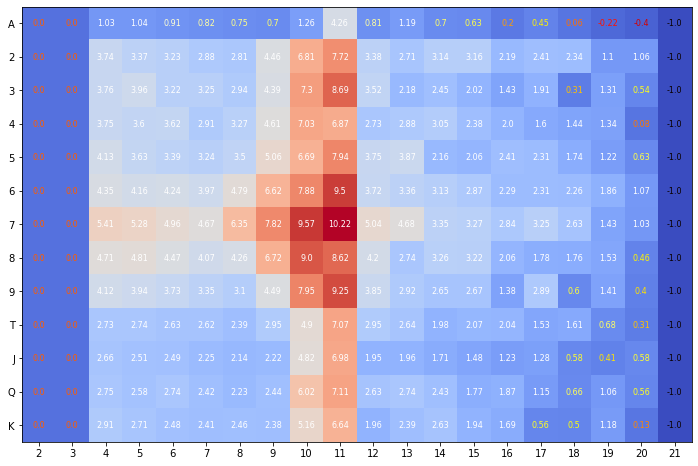

stay


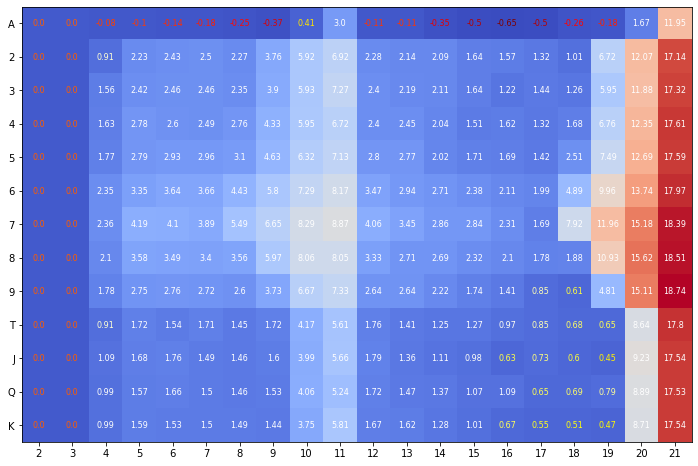

ace=11---------------------
hit


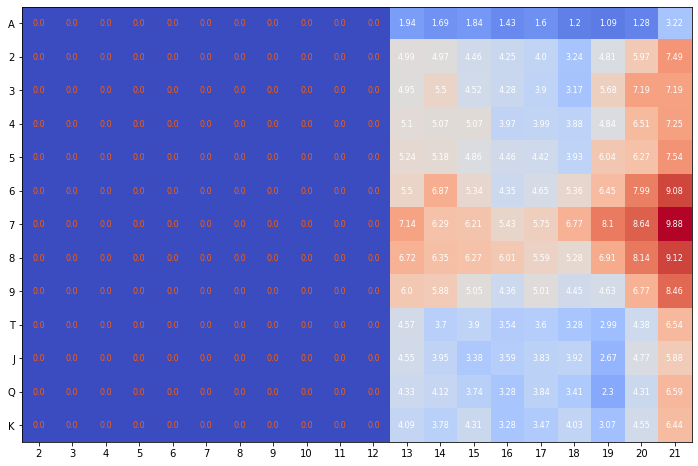

stay


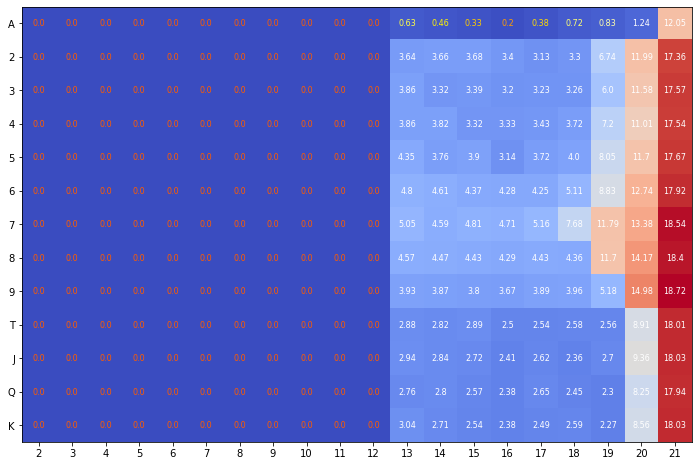

0

In [78]:
#TD
QTs = {'h': [Grid(), Grid()], 's':[Grid(), Grid()]} # first grid is UA=1 ,sec grid is False UA=0
action_space = ['h', 's']
eps = 0.1

def policy(s):
    if np.random.uniform(0,1) < eps:
        action = np.random.choice(action_space)
    else:
        values = {}
        for key in QTs.keys():
            values[key] = QTs[key][s[0]].getValue(s[1], s[2])
        action = max(values, key=values.get)
    return action

def update(s0, a0, r, s1):
    if s1 != None:
        pred = QTs[a0][s0[0]].getValue(s0[1], s0[2])
        _ = [QTs[a][s1[0]].getValue(s1[1], s1[2]) for a in action_space]
        y = r + 0.95*np.max(_)
        new = pred + 0.01*(y - pred)
        QTs[a0][s0[0]].updateValue(s0[1], s0[2], new)
    else:
        pred = QTs[a0][s0[0]].getValue(s0[1], s0[2])
        y = r
        new = pred + 0.01*(y - pred)
        QTs[a0][s0[0]].updateValue(s0[1], s0[2], new)



#TD Q-Learning main
M = 5000000
for m in range(M):
    if m%10000 == 0: print(m)
    env = Trial()
    s0 = env.s0
    for t in range(100):
        a0 = policy(s0)
        s1, r, done = env.next(s0, a0)
        update(s0, a0, r, s1)
        s0 = s1
        if done:
            break


Qhit = QTs['h']
Qstay = QTs['s']
print('ace=1--------------------')
print("hit")
Qhit[0].plotGrid()
print("stay")
Qstay[0].plotGrid()

print('ace=11---------------------')
print("hit")
Qhit[1].plotGrid()
print("stay")
Qstay[1].plotGrid()



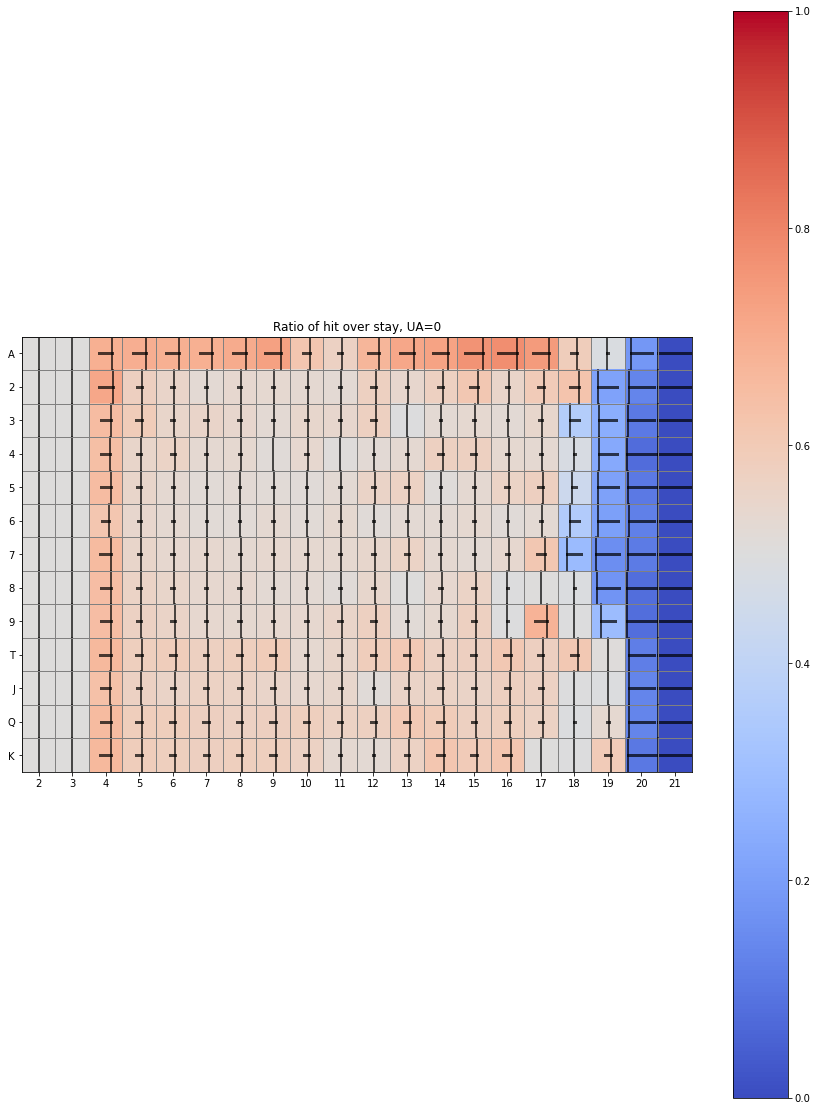

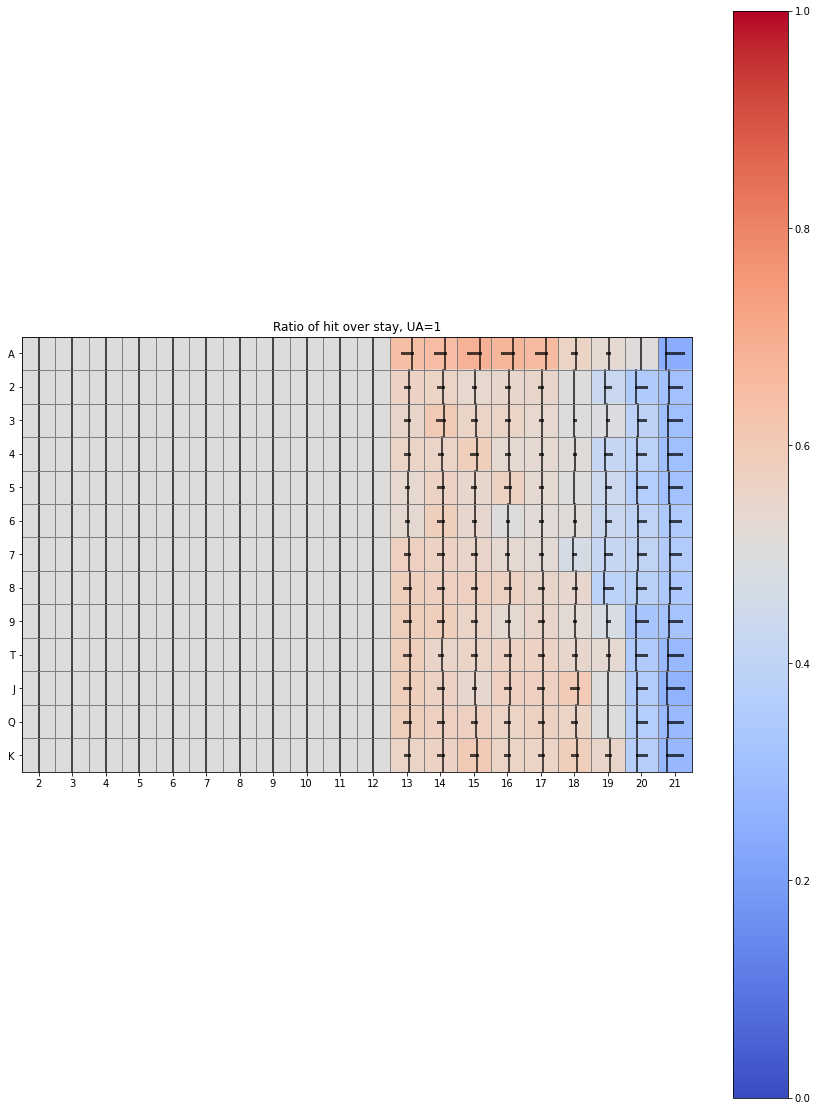

In [79]:
Q_UA0 = [QTs['h'][0].grid, QTs['s'][0].grid]
hit_score = Q_UA0[0]

stay_score = Q_UA0[1]
hit_norm  = (hit_score - (-1))/2
stay_norm = (stay_score - (-1))/2

# print(hit_norm[0][0])

#hit v.s. stay
ratios = hit_norm/(hit_norm + stay_norm)
# print(ratios)

fig, ax = plt.subplots(figsize=(15,20))
ax.set_xticks(np.arange(len(QTs['h'][0].col_indexes)), labels=QTs['h'][0].col_indexes)
ax.set_yticks(np.arange(len(QTs['h'][0].row_indexes)), labels=QTs['h'][0].row_indexes)
heatmap = ax.imshow(ratios, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=1)

for i in range(ratios.shape[0]):
    for j in range(ratios.shape[1]):
        ratio = ratios[i,j]
        #内部行动分割线
        ax.plot([j-0.5+ratio,j-0.5+ratio], [i-0.5, i+0.5], color='black', alpha=0.9, linewidth = 1.5)
        #方向指导线,长度=2*ratio,起始点在ratio处
        ax.plot([j-0.5+ratio,j+(0.5-ratio)], [i, i], color='black', alpha=0.7, linewidth = 3)
        #边缘线竖线
        ax.plot([j-0.5,j-0.5], [i-0.5, i+0.5], color='grey', linewidth = 1)
        ax.plot([j-0.5,j+0.5], [i-0.5, i-0.5], color='grey', linewidth = 1)

plt.title("Ratio of hit over stay, UA=0")
plt.colorbar(heatmap, ax=ax)


Q_UA1 = [QTs['h'][1].grid, QTs['s'][1].grid]
hit_score = Q_UA1[0]
stay_score = Q_UA1[1]
hit_norm  = (hit_score - (-1))/2
stay_norm = (stay_score - (-1))/2
ratios = hit_norm/(hit_norm + stay_norm)
fig, ax2 = plt.subplots(figsize=(15,20))
ax2.set_xticks(np.arange(len(QTs['h'][0].col_indexes)), labels=QTs['h'][0].col_indexes)
ax2.set_yticks(np.arange(len(QTs['h'][0].row_indexes)), labels=QTs['h'][0].row_indexes)
heatmap2 = ax2.imshow(ratios, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=1)

for i in range(ratios.shape[0]):
    for j in range(ratios.shape[1]):
        ratio = ratios[i,j]
        #内部行动分割线
        ax2.plot([j-0.5+ratio,j-0.5+ratio], [i-0.5, i+0.5], color='black', alpha=0.9, linewidth = 1.5)
        #
        ax2.plot([j-0.5+ratio,j+(0.5-ratio)], [i, i], color='black', alpha=0.7, linewidth = 3)
        #边缘线竖线
        ax2.plot([j-0.5,j-0.5], [i-0.5, i+0.5], color='grey', linewidth = 1)
        ax2.plot([j-0.5,j+0.5], [i-0.5, i-0.5], color='grey', linewidth = 1)

plt.title("Ratio of hit over stay, UA=1")
plt.colorbar(heatmap2, ax=ax2)
